In [30]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, f1_score, classification_report, silhouette_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pyod.models.abod import ABOD
from lime.lime_tabular import LimeTabularExplainer
from sklearn.cluster import KMeans
from collections import Counter, defaultdict
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, validation_curve, RandomizedSearchCV
from sklearn.tree._tree import TREE_LEAF
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2, l1
from keras.layers import Dropout
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier

In [2]:
df_ts_cont = pd.read_csv('df_ts_cont.csv', skipinitialspace=True)
df_ts_cont = df_ts_cont.drop(columns=['key'])
X_ts_cont = df_ts_cont.values
y_ts = np.load('valid_ts_genres.npy', allow_pickle=True)
X_ts_cont.shape, y_ts.shape

((9835, 19), (9835,))

In [3]:
X_ts_cont_train, X_ts_cont_test, y_ts_train, y_ts_test = train_test_split(X_ts_cont, y_ts, test_size=0.3,
                                                    random_state=100,stratify=y_ts)
X_ts_cont_train.shape, X_ts_cont_test.shape, y_ts_train.shape, y_ts_test.shape

((6884, 19), (2951, 19), (6884,), (2951,))

In [4]:
%%time
randomforest = RandomForestClassifier(n_estimators=150, 
                             criterion='gini', 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features=50, 
                             random_state=0, 
                             n_jobs=-1)
randomforest.fit(X_ts_cont_train, y_ts_train)

y_pred_test_ts = randomforest.predict(X_ts_cont_test)

print('Accuracy %s' % accuracy_score(y_ts_test, y_pred_test_ts))
print(classification_report(y_ts_test, y_pred_test_ts))

Accuracy 0.6604540833615723
                   precision    recall  f1-score   support

              emo       0.56      0.52      0.54       149
             folk       0.43      0.37      0.40       149
             goth       0.36      0.33      0.34       149
            happy       0.78      0.75      0.77       150
      heavy-metal       0.60      0.69      0.64       150
       honky-tonk       0.84      0.85      0.84       150
           j-idol       0.74      0.69      0.71       150
             kids       0.76      0.81      0.78       150
   minimal-techno       0.83      0.83      0.83       150
              mpb       0.47      0.55      0.51       149
          new-age       0.78      0.70      0.74       150
            opera       0.66      0.74      0.70       140
            piano       0.87      0.65      0.75       142
progressive-house       0.62      0.72      0.67       148
            salsa       0.75      0.83      0.79       150
        sertanejo       0.6

In [6]:
def rf_predict(X):
    return randomforest.predict(X)

def rf_predict_proba(X):
    return randomforest.predict_proba(X)

# local

# lime

In [7]:
lime_explainer = LimeTabularExplainer(
    X_ts_cont_train,
    feature_names=df_ts_cont.columns,
    class_names=[str(g) for g in np.unique(y_ts)], 
    discretize_continuous=False
)

In [8]:
%%time
contr_coluns = list(df_ts_cont.columns)
df_contr_ts_cont = pd.DataFrame(columns=contr_coluns)

for test_instance in X_ts_cont_test:
    
    test_exp = lime_explainer.explain_instance(test_instance, rf_predict_proba, num_features=19)
    exp_dict = list(test_exp.local_exp.values())[0]
    contr_sorted_by_feat_ind = sorted(exp_dict, key=lambda x: x[0])
    test_exp_features = [c[1] for c in contr_sorted_by_feat_ind]
    df_contr_ts_cont.loc[len(df_contr_ts_cont)] = test_exp_features


CPU times: total: 24min 21s
Wall time: 3min 26s


In [16]:
scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(df_contr_ts_cont)
df_contr_ts_cont_norm = pd.DataFrame(scaled_array, columns=contr_coluns)

In [19]:
df_contr_ts_cont_norm['t_genre'] = y_ts_test
df_contr_ts_cont_norm['p_genre'] = y_pred_test_ts

In [20]:
X_ts_to_cluster = df_contr_ts_cont_norm.iloc[:,:-2]
X_ts_to_cluster.shape

(2951, 19)

In [17]:
%%time
sse = []
sil = []
for k in range(2, 25):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=20)
    kmeans.fit(X_ts_to_cluster)
    sil.append(silhouette_score(X_ts_to_cluster, kmeans.labels_))
    sse.append(kmeans.inertia_)

CPU times: total: 11min 11s
Wall time: 1min 11s


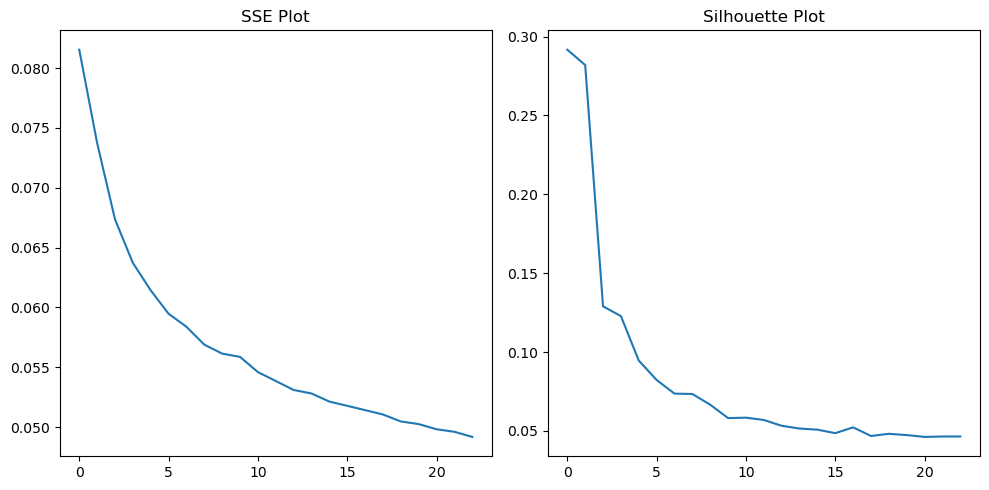

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(sse)
ax1.set_title('SSE Plot')
ax2.plot(sil)
ax2.set_title('Silhouette Plot')
plt.tight_layout()
plt.show()

In [19]:
kmeans = KMeans(n_clusters=9, random_state=0, n_init=50)
kmeans.fit(X_ts_to_cluster)
labels = kmeans.labels_

In [25]:
df_contr_ts_cont['cluster'] = labels
df_contr_ts_cont['cluster'].value_counts()

cluster
7    515
4    490
5    479
0    474
2    346
3    328
1    314
6      3
8      2
Name: count, dtype: int64

In [27]:
clusters = list(range(0,9))
contr_per_cluster = []
cluster_accuracies = []
for cluster in clusters:
    
    cluster_t_genre = df_contr_ts_cont[df_contr_ts_cont['cluster']==cluster]['t_genre'].values
    cluster_p_genre = df_contr_ts_cont[df_contr_ts_cont['cluster']==cluster]['p_genre'].values
    cluster_acc = (accuracy_score(cluster_t_genre, cluster_p_genre))
    cluster_accuracies.append(cluster_acc)

    cluster_contr = df_contr_ts_cont[df_contr_ts_cont['cluster']==cluster].iloc[:,:-3].mean().values
    contr_per_cluster.append(cluster_contr)

In [30]:
clusters_accuracy_dict = {i: cluster_accuracies[i] for i in range(9)}
print(clusters_accuracy_dict)

{0: 0.6603375527426161, 1: 0.7133757961783439, 2: 0.6936416184971098, 3: 0.8201219512195121, 4: 0.5877551020408164, 5: 0.6242171189979123, 6: 0.3333333333333333, 7: 0.6077669902912621, 8: 1.0}


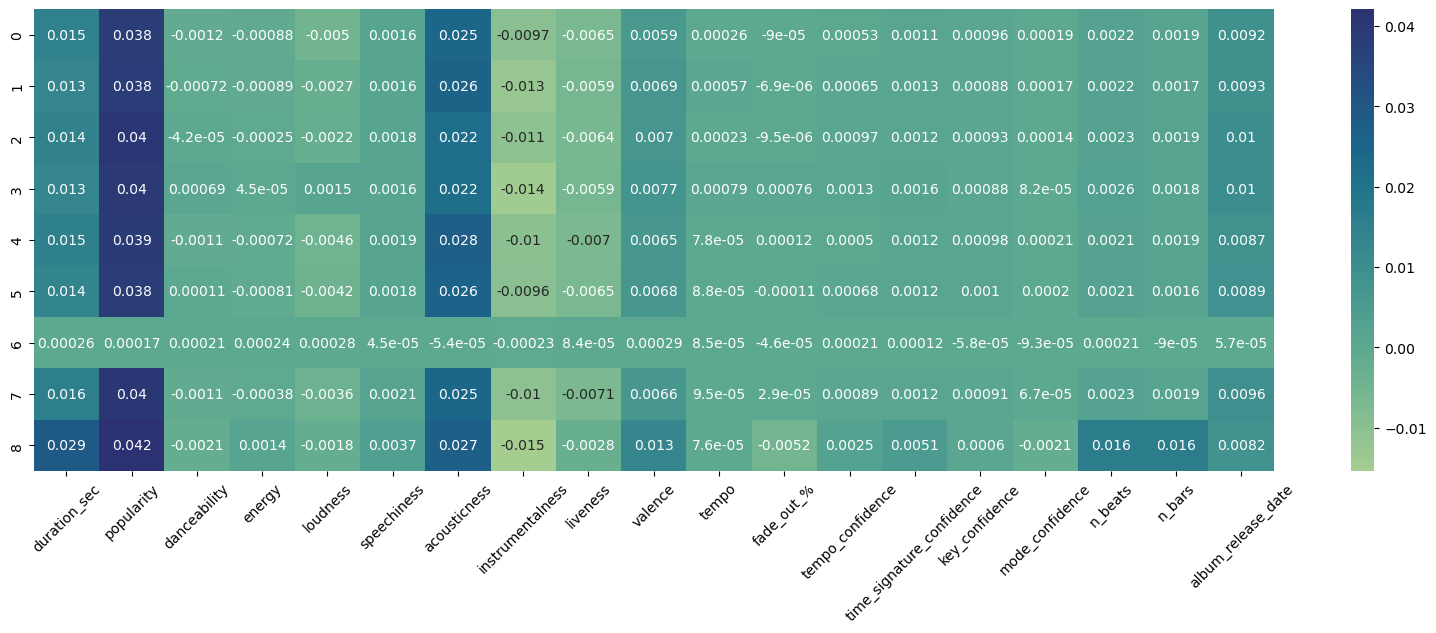

In [29]:
plt.figure(figsize=(20,6))
sns.heatmap(contr_per_cluster, annot=True, xticklabels=list(df_contr_ts_cont.columns[:-3]), cmap='crest')
plt.xticks(rotation=45)
plt.show()

In [31]:
df_contr_ts_cont.describe()

,duration_sec,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,fade_out_%,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_beats,n_bars,album_release_date,cluster
count,2951.000000,2.951000e+03,2951.000000,2951.000000,2951.000000,2951.000000,2951.000000,2.951000e+03,2951.000000,2.951000e+03,2951.000000,2951.000000,2951.000000,2951.000000,2951.000000,2951.000000,2951.000000,2951.000000,2.951000e+03,2951.000000
mean,0.014467,3.909187e-02,-0.000540,-0.000578,-0.003252,0.001794,0.024975,-1.083375e-02,-0.006549,6.693713e-03,0.000261,0.000072,0.000765,0.001222,0.000939,0.000152,0.002255,0.001816,9.368205e-03,3.383260
std,0.001497,1.942988e-03,0.001251,0.000971,0.002194,0.000972,0.002302,1.883094e-03,0.001086,1.177076e-03,0.000967,0.001034,0.000960,0.000979,0.000916,0.000936,0.001013,0.001035,1.199900e-03,2.340327
min,-0.002451,8.035488e-08,-0.004796,-0.004191,-0.007846,-0.007259,-0.000187,-1.809004e-02,-0.010228,1.072222e-07,-0.003174,-0.006794,-0.002585,-0.002048,-0.002124,-0.003767,-0.002288,-0.002990,9.057392e-08,0.000000
25%,0.013606,3.817649e-02,-0.001405,-0.001232,-0.004753,0.001145,0.023532,-1.170882e-02,-0.007294,5.895021e-03,-0.000405,-0.000623,0.000121,0.000540,0.000325,-0.000461,0.001636,0.001179,8.581236e-03,1.000000
50%,0.014505,3.908742e-02,-0.000595,-0.000597,-0.003720,0.001791,0.025268,-1.040621e-02,-0.006533,6.647679e-03,0.000254,0.000041,0.000765,0.001192,0.000943,0.000158,0.002251,0.001793,9.330367e-03,4.000000
75%,0.015409,4.012434e-02,0.000235,0.000056,-0.002451,0.002427,0.026540,-9.539185e-03,-0.005840,7.440593e-03,0.000883,0.000767,0.001373,0.001840,0.001566,0.000750,0.002856,0.002472,1.012718e-02,5.000000
max,0.033533,4.439898e-02,0.005710,0.002858,0.007358,0.005779,0.030751,-9.472443e-08,0.000138,1.367359e-02,0.003713,0.003941,0.005132,0.007726,0.005422,0.003889,0.022767,0.020912,1.433702e-02,8.000000


In [35]:
mintec_correct = df_contr_ts_cont[(df_contr_ts_cont['t_genre']=='minimal-techno') & 
                          (df_contr_ts_cont['t_genre']==df_contr_ts_cont['p_genre'])]
mintec_wrong = df_contr_ts_cont[(df_contr_ts_cont['t_genre']=='minimal-techno') & 
                          (df_contr_ts_cont['t_genre']!=df_contr_ts_cont['p_genre'])]
mintec_correct_values = mintec_correct.iloc[:,:-3].mean().values
mintec_wrong_values = mintec_wrong.iloc[:,:-3].mean().values
diff = np.array([mintec_wrong_values, mintec_correct_values])

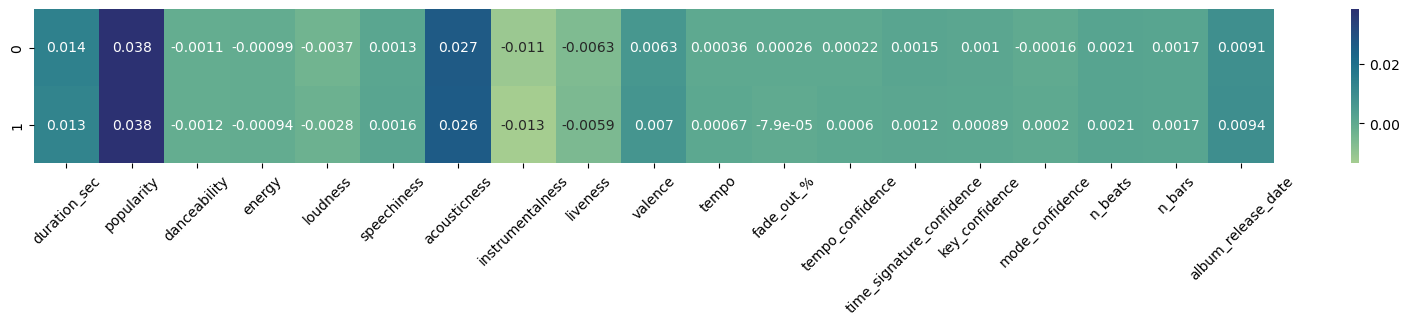

In [36]:
plt.figure(figsize=(20,2))
sns.heatmap(diff, annot=True, xticklabels=list(df_contr_ts_cont.columns[:-3]), cmap='crest')
plt.xticks(rotation=45)
plt.show()

# OUTLIER DETECTION


In [77]:
df_contr_ts_cont

,duration_sec,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_beats,n_bars,album_release_date,t_genre,p_genre,cluster
0,0.015475,0.040527,-0.001210,-0.000725,-0.006420,0.002714,0.027040,-0.009485,-0.007131,0.007197,...,0.000898,0.002179,0.001521,0.000759,0.001973,0.002477,0.009373,progressive-house,progressive-house,4
1,0.014354,0.038702,-0.002584,-0.001120,-0.005165,0.002506,0.025329,-0.009010,-0.006583,0.006104,...,0.000294,0.000836,-0.001279,0.000258,0.002977,0.000157,0.009175,mpb,emo,0
2,0.016541,0.037827,-0.002163,-0.001360,-0.004719,0.002665,0.023407,-0.010445,-0.006971,0.005666,...,0.001186,0.000205,0.000661,0.001122,0.002779,0.001194,0.009318,sertanejo,honky-tonk,0
3,0.017657,0.040263,-0.001236,-0.001044,-0.004992,0.002107,0.024296,-0.010938,-0.006880,0.005611,...,-0.000853,0.000036,0.000122,0.001223,0.000976,0.002797,0.008589,salsa,salsa,7
4,0.014821,0.040892,-0.001162,-0.001365,-0.004686,0.002697,0.024840,-0.011520,-0.009165,0.007567,...,0.001213,0.001049,0.001469,0.000098,0.002333,0.002655,0.009056,emo,mpb,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,0.014198,0.040339,-0.002474,-0.001091,-0.004079,0.001889,0.028049,-0.011195,-0.005563,0.006751,...,0.001553,0.001042,-0.000536,-0.000117,0.003770,0.000832,0.009142,goth,kids,4
2947,0.013783,0.040994,-0.000185,-0.001874,-0.004329,0.002728,0.027324,-0.009586,-0.006509,0.005504,...,0.002054,0.000098,0.000438,0.000949,0.001011,0.002293,0.009759,goth,heavy-metal,5
2948,0.017310,0.040838,-0.002663,-0.000255,-0.005065,0.003671,0.024887,-0.011917,-0.006636,0.007520,...,0.002192,0.001589,0.001861,-0.000769,0.003848,0.002349,0.008639,salsa,salsa,7
2949,0.015597,0.039293,-0.001550,-0.000382,-0.004678,0.000828,0.028235,-0.008455,-0.006143,0.007422,...,-0.000428,0.000236,0.000440,0.001093,0.002811,0.000898,0.009427,synth-pop,mpb,4


In [78]:
X_outliers = df_contr_ts_cont.values[:,:-3]
X_outliers.shape

(2951, 19)

In [80]:
%%time
isofor = IsolationForest(random_state=0)
isofor.fit(X_outliers)
IF_anom_score = isofor.score_samples(X_outliers)

CPU times: total: 172 ms
Wall time: 167 ms


In [81]:
def sort_array_ascending_with_indexes(arr):
    arr_with_indexes = [(arr[i], i) for i in range(len(arr))]
    arr_with_indexes.sort(reverse=False)
    sorted_indexes = [pair[1] for pair in arr_with_indexes]
    return sorted_indexes

In [83]:
anomalies_index_IF = sort_array_ascending_with_indexes(IF_anom_score)
top1_anomalies_IF = anomalies_index_IF[:100]

IF_df_anom = df_contr_ts_cont.loc[top1_anomalies_IF]

ABOD

In [87]:
%%time
abod = ABOD(contamination=0.01, n_neighbors=5, method='fast')
abod.fit(X_outliers)
abod_dec_scores = abod.decision_scores_

CPU times: total: 3.31 s
Wall time: 2.29 s


In [88]:
def sort_array_descending_with_indexes(arr):
    arr_with_indexes = [(arr[i], i) for i in range(len(arr))]
    arr_with_indexes.sort(reverse=True)
    sorted_indexes = [pair[1] for pair in arr_with_indexes]
    return sorted_indexes

anomalies_index = sort_array_descending_with_indexes(abod_dec_scores)
top1_anomalies_abod = anomalies_index[:100]
abod_df_anom = df_contr_ts_cont.loc[top1_anomalies_abod]

osserviamo i comuni fra ABOD e IF

In [90]:
inters_out = set(top1_anomalies_abod).intersection(set(top1_anomalies_IF))
df_contr_outlier = df_contr_ts_cont.loc[list(inters_out)]

In [91]:
df_contr_outlier

,duration_sec,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_beats,n_bars,album_release_date,t_genre,p_genre,cluster
514,0.013681,0.037478,0.002082,0.001102,0.004050,0.000646,0.023162,-0.015353,-0.006925,0.008229,...,0.003897,0.003174,0.001532,-0.001013,0.003004,0.003709,0.011856,sleep,sleep,3
1282,0.015103,0.038898,0.001773,0.001946,0.003151,0.002929,0.020675,-0.011777,-0.006950,0.010170,...,0.000886,0.005706,-0.000947,0.000391,0.002903,0.001000,0.009416,opera,opera,3
523,0.013135,0.040917,0.001843,0.000233,0.004422,0.002042,0.022575,-0.016155,-0.002835,0.011293,...,0.000889,0.001602,0.002273,0.000166,0.002952,0.000010,0.011131,sleep,sleep,3
149,0.013068,0.041120,-0.001216,0.000749,0.000860,0.002958,0.021667,-0.013562,-0.005790,0.004917,...,0.002780,0.004463,-0.001262,-0.002314,0.003455,-0.000163,0.009398,piano,piano,3
1176,0.013942,0.039509,0.002049,-0.001056,0.001124,-0.000195,0.019724,-0.015431,-0.005633,0.006652,...,0.000307,0.000199,0.002104,-0.000262,0.002196,0.001809,0.010081,new-age,piano,3
1050,0.011407,0.031877,-0.001156,0.001684,-0.003070,0.005259,0.016764,-0.008989,-0.003435,0.007046,...,-0.000792,0.002040,0.000864,-0.001179,0.000596,-0.001499,0.006643,kids,sleep,2
156,0.014718,0.035639,0.005710,0.002475,0.005477,0.003740,0.021467,-0.011622,-0.006455,0.009007,...,0.002606,0.006056,0.002217,0.003656,0.005601,0.003189,0.008558,sleep,sleep,3
670,0.013902,0.035479,0.004887,-0.000379,0.003221,0.001720,0.023022,-0.012855,-0.006544,0.007059,...,0.003138,0.001746,0.000678,0.001634,0.003865,0.003248,0.008171,sleep,sleep,3
1823,0.012994,0.042189,0.002996,-0.000844,0.002821,0.004372,0.023093,-0.016495,-0.005452,0.010245,...,0.002769,0.001684,0.001366,0.001165,0.002871,0.000528,0.011610,opera,sleep,3
1696,0.015042,0.037926,0.002649,0.000934,0.004937,-0.000247,0.020989,-0.011136,-0.003621,0.008747,...,0.002806,0.002395,0.001180,0.001048,0.003402,0.003600,0.008811,sleep,sleep,3


# TREPAN

# NN su techno sbilanciato 

In [21]:
df_track_cont_cat = pd.read_csv('df_track_cont_cat.csv', skipinitialspace=True)

In [22]:
df_track = pd.read_csv('df_track_no_duplicates.csv', skipinitialspace=True)

In [24]:
X_track = df_track_cont_cat.values[:,:20]
y_track = df_track['genre'].values
ybin= list()
for genre in y_track:
    if genre=='techno' or genre=='minimal-techno':
        ybin.append(1)
    else:
        ybin.append(0)

In [25]:
Counter(ybin)

Counter({0: 82092, 1: 1520})

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_track, ybin, test_size=0.3, random_state=100, stratify=ybin)

Epoch 1/500


C:\Users\jullo\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1464/1464 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9761 - loss: 0.1049 - val_accuracy: 0.9830 - val_loss: 0.0638
Epoch 2/500
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9807 - loss: 0.0691 - val_accuracy: 0.9833 - val_loss: 0.0578
Epoch 3/500
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9810 - loss: 0.0636 - val_accuracy: 0.9841 - val_loss: 0.0551
Epoch 4/500
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9813 - loss: 0.0621 - val_accuracy: 0.9845 - val_loss: 0.0542
Epoch 5/500
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9814 - loss: 0.0615 - val_accuracy: 0.9847 - val_loss: 0.0536
Epoch 6/500
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9819 - loss: 0.0608 - val_accuracy: 0.9850 - val_loss: 0.0529
Epoch 7/500
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9820 - loss: 0.0600 - val_accuracy: 0.9845 - val_loss: 0.0526
Epoch 8/500
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9828 - loss: 0.0592 - val_

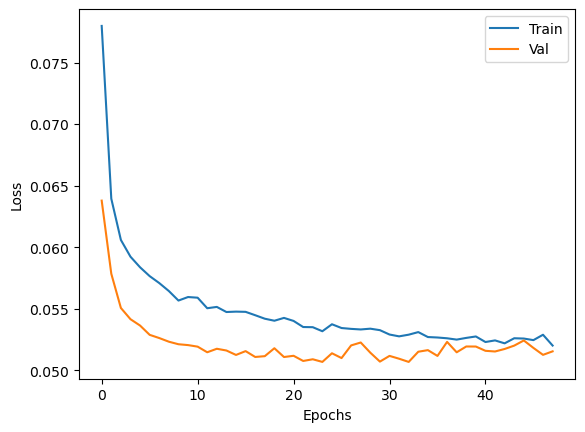

In [31]:
es = EarlyStopping(monitor='val_accuracy', patience=25, verbose=True)
n_classes=2

np.random.seed(42)
tf.random.set_seed(42)

def pazzo5():

    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer="adam", metrics=['accuracy'])
    return model


pazzo5 = KerasClassifier(pazzo5, callbacks=[es], random_state=42)
pazzo5.fit(X_train, y_train, validation_split=0.2, epochs=500)

y_pred = pazzo5.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

history = pazzo5.history_
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
y_pred_test_NN = y_pred
y_pred_train_NN = pazzo5.predict(X_train)

1829/1829 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step


In [33]:
%%time
param_dist = {
    'criterion': ['gini', 'entropy'],               
    'min_samples_split': np.arange(2, 20),         
    'min_samples_leaf': np.arange(1, 20)}

explainer = DecisionTreeClassifier(max_depth=4)

random_search = RandomizedSearchCV(
    explainer, 
    param_distributions=param_dist, 
    n_iter=100,      
    scoring='f1',    
    cv=5,            
    verbose=1,       
    n_jobs=-1,       
    random_state=42
)
random_search.fit(X_train, y_pred_train_NN)
best_exp = random_search.best_estimator_
best_exp.fit(X_train, y_pred_train_NN)
y_pred_test_best_exp = best_exp.predict(X_test)
best_exp_report = classification_report(y_test, y_pred_test_best_exp)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 2.11 s
Wall time: 19.6 s


In [34]:
#DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=9,min_samples_split=13)
best_exp

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=9,
                       min_samples_split=13)

In [35]:
y_pred_test_exp = best_exp.predict(X_test)
y_pred_train_exp = best_exp.predict(X_train)

In [36]:
print('------ report NN ------\n')
print(classification_report(y_test, y_pred_test_NN))
print('------ report Explainer ------\n')
print(classification_report(y_test, y_pred_test_exp))

------ report NN ------

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     24628
           1       0.66      0.34      0.45       456

    accuracy                           0.98     25084
   macro avg       0.82      0.67      0.72     25084
weighted avg       0.98      0.98      0.98     25084

------ report Explainer ------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     24628
           1       0.51      0.30      0.38       456

    accuracy                           0.98     25084
   macro avg       0.75      0.65      0.68     25084
weighted avg       0.98      0.98      0.98     25084



In [37]:
validity = accuracy_score(y_pred_train_NN, y_pred_train_exp)
print('Validity:', validity)

Validity: 0.9933023510114817


In [38]:
features = df_track_cont_cat.columns[:20]

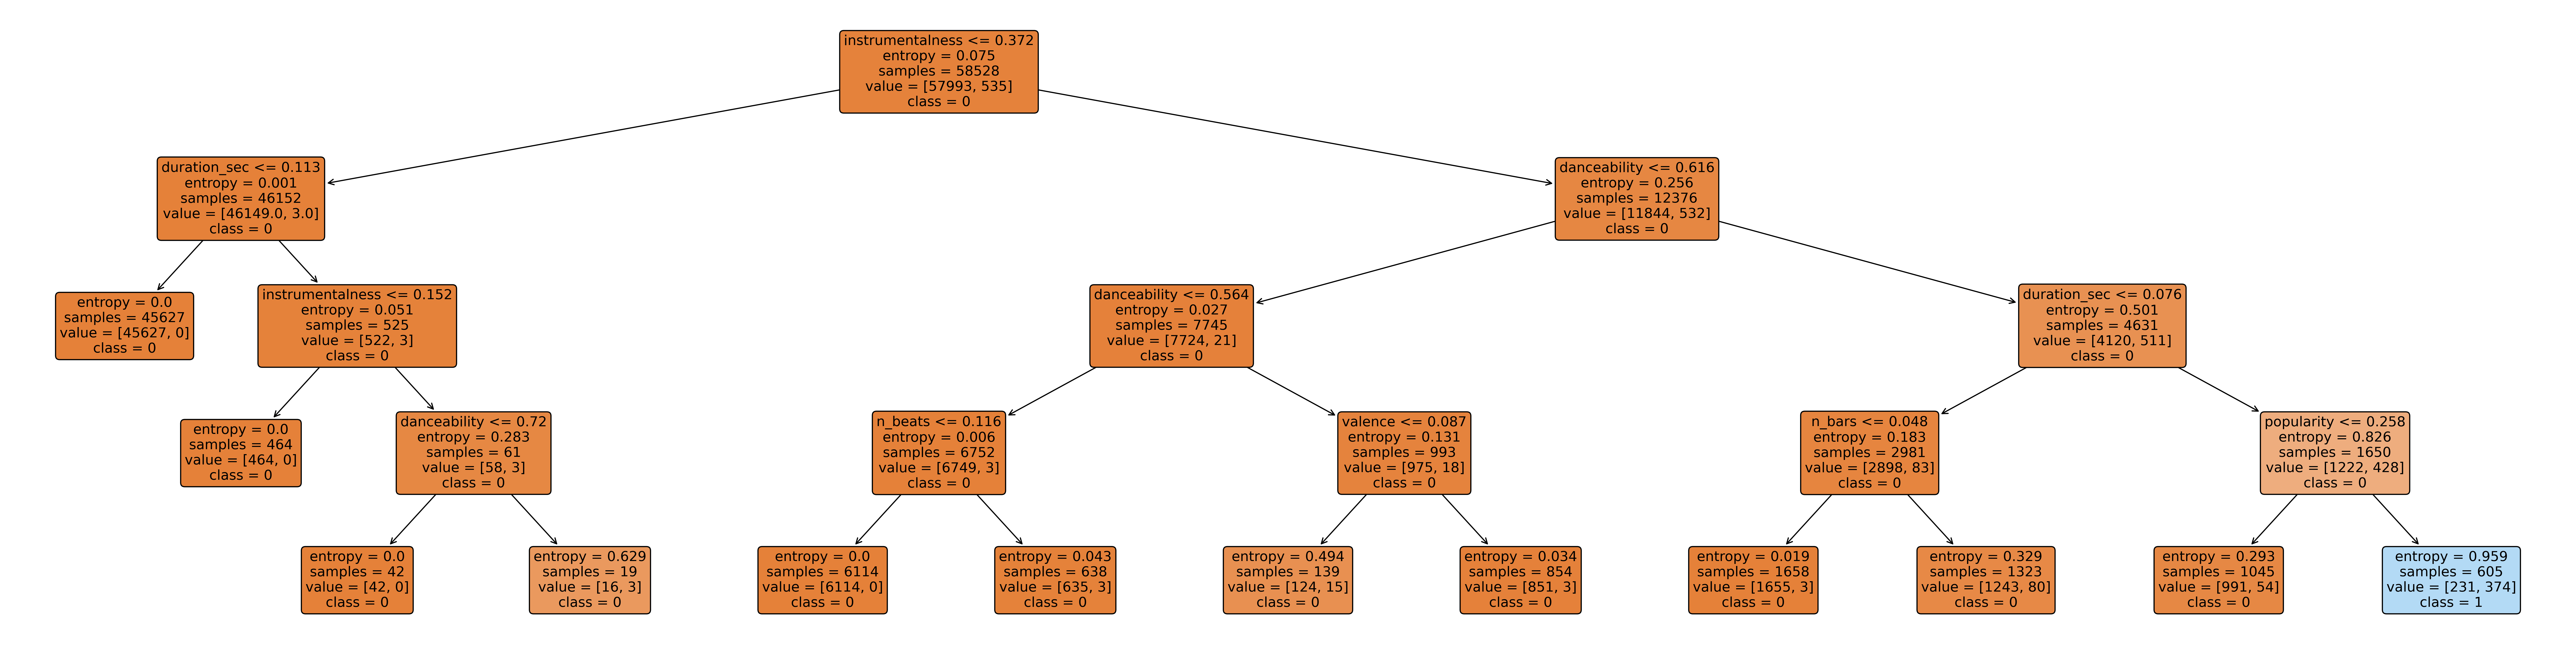

In [39]:
plt.figure(figsize=(40, 10), dpi=400)
plot_tree(best_exp,
          feature_names=features,
          class_names=['0', '1'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=None)  
plt.show()

In [40]:
importances = best_exp.feature_importances_
for feature, importance in zip(features, importances):
    print(f'{feature}: {importance}')

duration_sec: 0.14815800106708318
popularity: 0.16393775993907392
danceability: 0.23573444519863154
energy: 0.0
key: 0.0
loudness: 0.0
speechiness: 0.0
acousticness: 0.0
instrumentalness: 0.41002083848618015
liveness: 0.0
valence: 0.011198701291387834
tempo: 0.0
fade_out_%: 0.0
tempo_confidence: 0.0
time_signature_confidence: 0.0
key_confidence: 0.0
mode_confidence: 0.0
n_beats: 0.0035232013026159133
n_bars: 0.027427052715027506
album_release_date: 0.0


In [47]:
def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and
            inner_tree.children_right[index] == TREE_LEAF)


def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        # print("Pruned {}".format(index))


def prune_duplicate_leaves(dt):
    # Remove leaves if both
    decisions = dt.tree_.value.argmax(axis=2).flatten().tolist()  # Decision for each node
    prune_index(dt.tree_, decisions)
    
prune_duplicate_leaves(best_exp)

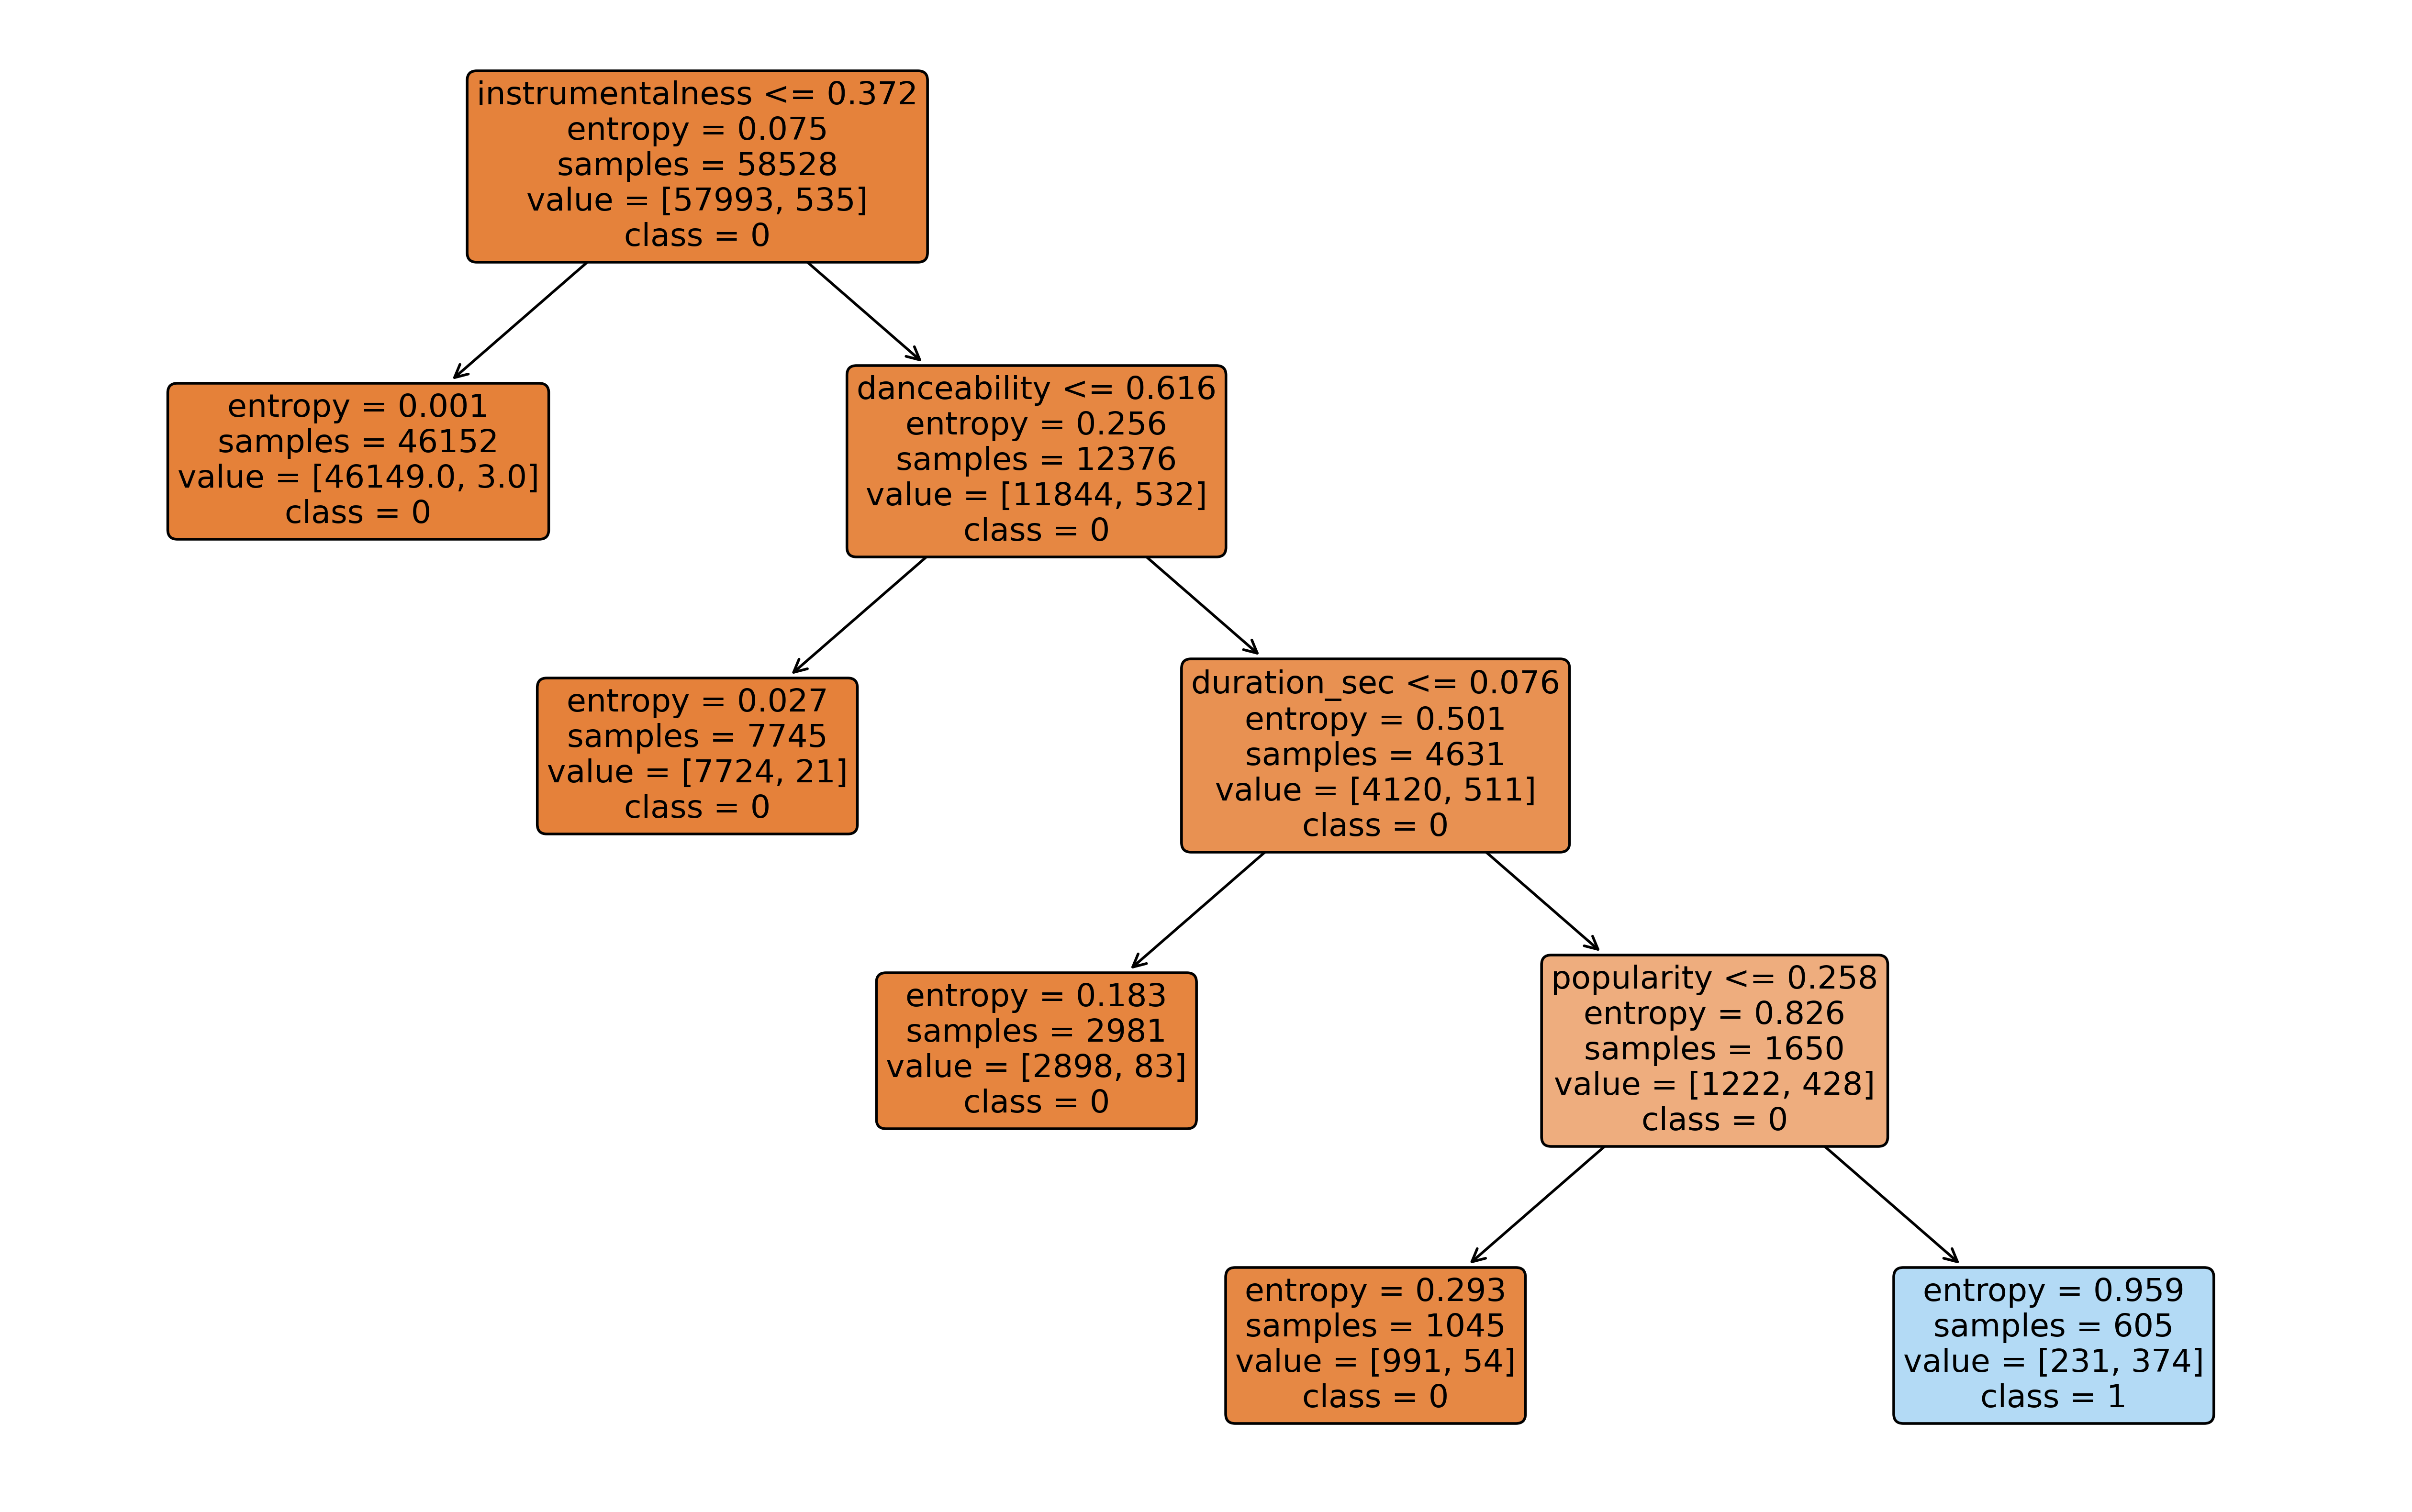

In [50]:
plt.figure(figsize=(16, 10), dpi=400)
plot_tree(best_exp,
          feature_names=features,
          class_names=['0', '1'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=None)  
plt.show()